In [19]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
plt.style.use('fivethirtyeight')
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
import pickle as pkl

from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn import preprocessing

In [39]:
pd.set_option('display.max_columns', None)

In [20]:
files = glob.glob('../BL_Work/openPrescribe/savings/*.gz')

In [21]:
ome = pd.read_csv('scratchpad/ome_rossano.csv')

In [22]:
ome['BNF_stub'] = ome['bnf'].apply(lambda x: x[:-2])

In [23]:
ome.head()

,bnf_name,bnf,mg_per_unit,ome_multiplier,BNF_stub
0,Abstral_Tab Sublingual 100mcg,0407020A0BJAAAW,0.1,130.0,0407020A0BJAA
1,Abstral_Tab Sublingual 200mcg,0407020A0BJABAX,0.2,130.0,0407020A0BJAB
2,Abstral_Tab Sublingual 300mcg,0407020A0BJACAY,0.3,130.0,0407020A0BJAC
3,Abstral_Tab Sublingual 400mcg,0407020A0BJADAZ,0.4,130.0,0407020A0BJAD
4,Abstral_Tab Sublingual 600mcg,0407020A0BJAEBA,0.6,130.0,0407020A0BJAE


In [24]:
with open('scratchpad/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('scratchpad/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [25]:
files = glob.glob('../BL_Work/openPrescribe/savings_Impact/*.h5')
files.sort()
print files

['../BL_Work/openPrescribe/savings_Impact/201406.h5', '../BL_Work/openPrescribe/savings_Impact/201407.h5', '../BL_Work/openPrescribe/savings_Impact/201408.h5', '../BL_Work/openPrescribe/savings_Impact/201409.h5', '../BL_Work/openPrescribe/savings_Impact/201410.h5', '../BL_Work/openPrescribe/savings_Impact/201411.h5', '../BL_Work/openPrescribe/savings_Impact/201412.h5', '../BL_Work/openPrescribe/savings_Impact/201501.h5', '../BL_Work/openPrescribe/savings_Impact/201502.h5', '../BL_Work/openPrescribe/savings_Impact/201503.h5', '../BL_Work/openPrescribe/savings_Impact/201504.h5', '../BL_Work/openPrescribe/savings_Impact/201505.h5', '../BL_Work/openPrescribe/savings_Impact/201506.h5', '../BL_Work/openPrescribe/savings_Impact/201507.h5', '../BL_Work/openPrescribe/savings_Impact/201508.h5', '../BL_Work/openPrescribe/savings_Impact/201509.h5', '../BL_Work/openPrescribe/savings_Impact/201510.h5', '../BL_Work/openPrescribe/savings_Impact/201511.h5', '../BL_Work/openPrescribe/savings_Impact/2015

In [28]:
files[19]

'../BL_Work/openPrescribe/savings_Impact/201601.h5'

In [29]:
pdp = pd.read_hdf(files[19])
pdp.dropna()
for file in files[19:19+3]:
    pdp2 = pd.read_hdf(file)
    pdp2.dropna()
    pdp.append(pdp2)

In [30]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 51135        59964  Q44  01R  N81084  0101010C0BBAAAA   
  55454        64283  Q44  01R  N81614  0101010C0AAAAAA   
  69323        78846  Q44  02D  N81087  0101010C0AAAAAA   
  81064        91133  Q44  02E  N81020  0101010C0AAAAAA   
  104971      115040  Q44  02E  N81122  0101010C0BBAAAA   

                                                 4    5      6      7      8  \
0 51135   Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   
  55454   Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  69323   Alum Hydrox_Cap 475mg                     1.0  31.99  29.66  280.0   
  81064   Alum Hydrox_Cap 475mg                     2.0  25.60  23.86  224.0   
  104971  Alu-Cap_Cap 475mg                         1.0  19.19  17.84  168.0   

          ...     15         16          17   18          19  20        21  \
0 51135   ...  475.0  0101010C0  112.000000  1.0  112.000000  BB  0.110952   
  55454   ...  475.0  0101010C0   40.000000  1.0   40.000000  AA  0.110952   
  69323   ...  475.0  0101010C0   93.333333  1.0   93.333333  AA  0.110952   
  81064   ...  475.0  0101010C0   74.666667  1.0   74.666667  AA  0.110952   
  104971  ...  475.0  0101010C0   56.000000  1.0   56.000000  BB  0.110952   

                22         23        24  
0 51135   0.143333  10.880000  1.413690  
  55454   0.143333   3.885714  3.958333  
  69323   0.143333   9.066667  1.696429  
  81064   0.143333   7.253333  2.120536  
  104971  0.143333   5.440000  2.827381  

[5 rows x 26 columns]

In [31]:
len(pdp)

9046629

In [32]:
bnf_ome_map_df = {'BNF' : [] , 'OME':[] , 'BNF_variants' : []}
for name , group in ome.groupby('BNF_stub'):
    bnf_ome_map_df['BNF'].append(name)
    bnf_ome_map_df['BNF_variants'].append(set(group['bnf_name']))
    bnf_ome_map_df['OME'].append(list(set(group['ome_multiplier']))[0])
bnf_ome_map_df = pd.DataFrame.from_dict(bnf_ome_map_df)

In [33]:
bnf_ome_map = {}
for name , group in ome.groupby('BNF_stub'):
#     if list(set(group['ome_multiplier']))[0] < 0:
    bnf_ome_map[name] = list(set(group['ome_multiplier']))[0]

In [34]:
bnf_ome_map_df.head()

,BNF,BNF_variants,OME
0,040702020AAAA,{Morph/Cyclizine_Inj 10mg/50mg 1ml Amp},2.0
1,040702020AAAB,{Morph/Cyclizine_Inj 15mg/50mg 1ml Amp},2.0
2,040702020BBAA,{Cyclimorph 10_Inj 1ml Amp},2.0
3,040702020BBAB,{Cyclimorph 15_Inj 1ml Amp},2.0
4,040702040AAAA,{Tramadol HCl_Cap 50mg},0.1


In [42]:
bnf_ome_map = {}
for index, row in bnf_ome_map_df.iterrows():
    bnf_ome_map[row['BNF']] = row['OME']

In [44]:
# bnf_ome_map

In [58]:
 bnf_ome_map_df[bnf_ome_map_df['OME'] > 10]

,BNF,BNF_variants,OME
129,0407020A0AAAE,{Fentanyl_Transdermal Patch 25mcg/hr},100.0
130,0407020A0AAAF,{Fentanyl_Transdermal Patch 50mcg/hr},100.0
131,0407020A0AAAG,{Fentanyl_Transdermal Patch 75mcg/hr},100.0
132,0407020A0AAAH,{Fentanyl_Transdermal Patch 100mcg/hr},100.0
133,0407020A0AAAI,{Fentanyl_Loz 200mcg},100.0
134,0407020A0AAAJ,{Fentanyl_Loz 400mcg},100.0
135,0407020A0AAAK,{Fentanyl_Loz 600mcg},100.0
136,0407020A0AAAL,{Fentanyl_Loz 800mcg},100.0
137,0407020A0AAAN,{Fentanyl_Loz 1.2mg},100.0
138,0407020A0AAAP,{Fentanyl_Loz 1.6mg},100.0


In [35]:
pdp['25'] = pdp['3'].apply(lambda x : x[:-2])

In [36]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 51135        59964  Q44  01R  N81084  0101010C0BBAAAA   
  55454        64283  Q44  01R  N81614  0101010C0AAAAAA   
  69323        78846  Q44  02D  N81087  0101010C0AAAAAA   
  81064        91133  Q44  02E  N81020  0101010C0AAAAAA   
  104971      115040  Q44  02E  N81122  0101010C0BBAAAA   

                                                 4    5      6      7      8  \
0 51135   Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   
  55454   Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  69323   Alum Hydrox_Cap 475mg                     1.0  31.99  29.66  280.0   
  81064   Alum Hydrox_Cap 475mg                     2.0  25.60  23.86  224.0   
  104971  Alu-Cap_Cap 475mg                         1.0  19.19  17.84  168.0   

          ...         16          17   18          19  20        21        22  \
0 51135   ...  0101010C0  112.000000  1.0  112.000000  BB  0.110952  0.143333   
  55454   ...  0101010C0   40.000000  1.0   40.000000  AA  0.110952  0.143333   
  69323   ...  0101010C0   93.333333  1.0   93.333333  AA  0.110952  0.143333   
  81064   ...  0101010C0   74.666667  1.0   74.666667  AA  0.110952  0.143333   
  104971  ...  0101010C0   56.000000  1.0   56.000000  BB  0.110952  0.143333   

                 23        24             25  
0 51135   10.880000  1.413690  0101010C0BBAA  
  55454    3.885714  3.958333  0101010C0AAAA  
  69323    9.066667  1.696429  0101010C0AAAA  
  81064    7.253333  2.120536  0101010C0AAAA  
  104971   5.440000  2.827381  0101010C0BBAA  

[5 rows x 27 columns]

In [37]:
opioids_ome = pdp[pdp['25'].isin(ome['BNF_stub'])]

In [41]:
opioids_ome.head(n=100)

Unnamed: 0    0    1       2                3  \
494 168748       182864  Q44  12F  N85008  040702020BBABAB   
    1358838     1511460  Q48  01V  N84021  040702020BBAAAA   
    1696351     1883688  Q49  01H  A82037  040702020BBAAAA   
    2172098     2429047  Q51  02Q  C84008  040702020AAABAB   
    2212315     2473273  Q51  02X  C86022  040702020BBABAB   
    3026389     3362287  Q53  05T  M81008  040702020BBABAB   
    3852039     4277181  Q55  04R  C81069  040702020BBAAAA   
    3873720     4300814  Q55  04R  C81652  040702020BBABAB   
    3882663     4311532  Q56  06H  D81004  040702020AAAAAA   
    3903385     4338334  Q56  06H  D81022  040702020BBABAB   
    3941099     4379255  Q56  06H  D81050  040702020BBABAB   
    3981936     4427836  Q56  06H  D81623  040702020BBAAAA   
    4056975     4505861  Q56  06L  D83079  040702020BBABAB   
    4061165     4510051  Q56  06L  D83082  040702020BBABAB   
    4101617     4560012  Q56  06V  D82005  040702020AAAAAA   
    4163454     4623788  Q56  06Y  D82006  040702020BBABAB   
    4210984     4672515  Q56  07J  D82051  040702020BBABAB   
    4245880     4707504  Q56  07K  D83029  040702020BBAAAA   
    4288637     4750367  Q57  06Q  F81074  040702020AAAAAA   
    4689998     5190581  Q58  04G  K83064  040702020BBAAAA   
    4764713     5272193  Q58  06F  E81057  040702020BBABAB   
    4820382     5334680  Q58  06K  E82067  040702020BBABAB   
    5504087     6084074  Q60  05W  M83021  040702020AAAAAA   
    5560513     6152386  Q60  05X  M82028  040702020BBAAAA   
    6863733     7585882  Q63  08X  H85003  040702020AAAAAA   
    6927662     7654071  Q64  11E  L81072  040702020BBABAB   
    6952177     7682327  Q64  11M  L84011  040702020BBAAAA   
    6975075     7709748  Q64  11M  L84031  040702020BBABAB   
    7016597     7755139  Q64  11M  L84065  040702020BBABAB   
    7028937     7767479  Q64  11M  L84078  040702020BBABAB   
...                 ...  ...  ...     ...              ...   
495 3789           7151  Q44  01C  N81022  040702040BNADAE   
    3790           7152  Q44  01C  N81022  040702040BNAFAC   
    5381           8743  Q44  01C  N81026  040702040AAAAAA   
    5382           8744  Q44  01C  N81026  040702040AAAHAH   
    5383           8745  Q44  01C  N81026  040702040AAAUAU   
    5384           8746  Q44  01C  N81026  040702040BNADAE   
    5385           8747  Q44  01C  N81026  040702040BNAEAD   
    5386           8748  Q44  01C  N81026  040702040BNAFAC   
    5387           8749  Q44  01C  N81026  040702040BPAAAG   
    7167          10529  Q44  01C  N81027  040702040AAAAAA   
    7168          10530  Q44  01C  N81027  040702040AAAEAE   
    7169          10531  Q44  01C  N81027  040702040AAAHAH   
    7170          10532  Q44  01C  N81027  040702040AAAJAJ   
    7171          10533  Q44  01C  N81027  040702040AAAUAU   
    7172          10534  Q44  01C  N81027  040702040BBACAC   
    7173          10535  Q44  01C  N81027  040702040BBAEAE   
    7174          10536  Q44  01C  N81027  040702040BIABAE   
    7175          10537  Q44  01C  N81027  040702040BIACAM   
    7176          10538  Q44  01C  N81027  040702040BNADAE   
    7177          10539  Q44  01C  N81027  040702040BNAEAD   
    7178          10540  Q44  01C  N81027  040702040BNAFAC   
    9199          12561  Q44  01C  N81029  040702040AAAAAA   
    9200          12562  Q44  01C  N81029  040702040AAAFAF   
    9201          12563  Q44  01C  N81029  040702040AAAHAH   
    9202          12564  Q44  01C  N81029  040702040BNAEAD   
    9203          12565  Q44  01C  N81029  040702040BNAFAC   
    9204          12566  Q44  01C  N81029  040702040BPAAAG   
    10939         14301  Q44  01C  N81033  040702040AAAAAA   
    10940         14302  Q44  01C  N81033  040702040AAAUAU   
    10941         14303  Q44  01C  N81033  040702040BDAGAT   

                                                    4      5       6       7  \
494 168748   Cyclimorph 15_Inj 1ml Amp                   4.0  109.44  101.13   
    1358

In [46]:
def func_ome(df,drugBNF,ome_map):
    df['26'] = df['8'] * ome_map[drugBNF]
    return df
    

def calculateOME(pdp,ome_map):
    pdp['26'] = 0.0
    return pdp.groupby('25',as_index=False).apply(lambda df: func_ome(df , df.name, ome_map ))

ome_df = calculateOME(opioids_ome , bnf_ome_map)

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [48]:
bnf_ome_map['040702020BBAB']

2.0

In [47]:
ome_df.head()

Unnamed: 0    0    1       2                3  \
494 168748       182864  Q44  12F  N85008  040702020BBABAB   
    1358838     1511460  Q48  01V  N84021  040702020BBAAAA   
    1696351     1883688  Q49  01H  A82037  040702020BBAAAA   
    2172098     2429047  Q51  02Q  C84008  040702020AAABAB   
    2212315     2473273  Q51  02X  C86022  040702020BBABAB   

                                                    4    5       6       7  \
494 168748   Cyclimorph 15_Inj 1ml Amp                 4.0  109.44  101.13   
    1358838  Cyclimorph 10_Inj 1ml Amp                 1.0   43.85   40.51   
    1696351  Cyclimorph 10_Inj 1ml Amp                 2.0   31.58   29.40   
    2172098  Morph/Cyclizine_Inj 15mg/50mg 1ml Amp     3.0    5.46    5.04   
    2212315  Cyclimorph 15_Inj 1ml Amp                 2.0   27.36   25.30   

                8         9        10         11   12    13  \
494 168748   60.0  201601.0  CH49 5PL  040702020  NaN  pain   
    1358838  25.0  201601.0   PR9 0TZ  040702020  NaN  pain   
    1696351  18.0  201601.0   CA7 4AH  040702020  NaN  pain   
    2172098   3.0  201601.0  NG22 0HT  040702020  NaN  pain   
    2212315  15.0  201601.0   DN2 5JH  040702020  NaN  pain   

                                                 14    15         16    17  \
494 168748   Morphine Tartrate & Cyclizine Tartrate  15.0  040702020  60.0   
    1358838  Morphine Tartrate & Cyclizine Tartrate  10.0  040702020  25.0   
    1696351  Morphine Tartrate & Cyclizine Tartrate  10.0  040702020  18.0   
    2172098  Morphine Tartrate & Cyclizine Tartrate  50.0  040702020   3.0   
    2212315  Morphine Tartrate & Cyclizine Tartrate  15.0  040702020  15.0   

              18    19  20    21    22     23         24             25     26  
494 168748   1.5  90.0  BB  1.00  1.68  40.80   0.250000  040702020BBAB  120.0  
    1358838  1.0  25.0  BB  1.00  1.62  15.50   0.400000  040702020BBAA   50.0  
    1696351  1.0  18.0  BB  1.00  1.62  11.16   0.555556  040702020BBAA   36.0  
    2172098  5.0  15.0  AA  1.62  1.00   0.00  16.666667  040702020AAAB    6.0  
    2212315  1.5  22.5  BB  1.00  1.68  10.20   1.000000  040702020BBAB   30.0

In [56]:
ome_df_new = ome_df[ome_df['15']>0]

In [62]:
ome_df_new['27'] = 1/ome_df_new['24']

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
ome_df_new['28'] = ome_df_new['26']/ome_df_new['8']

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5,0,'ln(ome)')

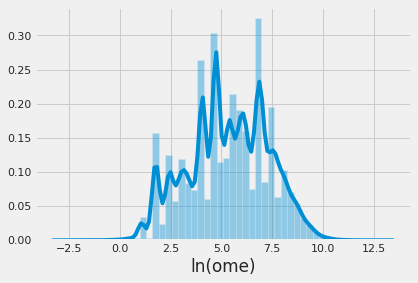

In [74]:
sns.distplot(np.log(ome_df_new['26']))
plt.xlabel('ln(ome)')

Text(0.5,0,'ln(Quantity/Potency)')

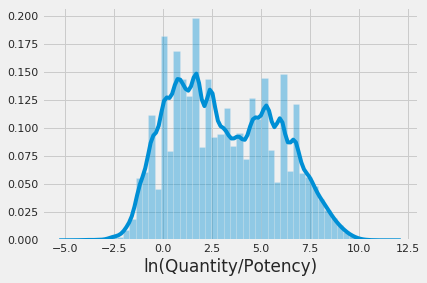

In [76]:
sns.distplot(np.log(ome_df_new['27']))
plt.xlabel('ln(Quantity/Potency)')

In [83]:
pearsonr(np.log(ome_df_new['28']) ,np.log(ome_df_new['15']))

(-0.9322595462811885, 0.0)

In [78]:
sub_df = ome_df_new[['24','26','27','15','4']]
sub_df.head()

24     26    27    15  \
494 168748    0.250000  120.0  4.00  15.0   
    1358838   0.400000   50.0  2.50  10.0   
    1696351   0.555556   36.0  1.80  10.0   
    2172098  16.666667    6.0  0.06  50.0   
    2212315   1.000000   30.0  1.00  15.0   

                                                    4  
494 168748   Cyclimorph 15_Inj 1ml Amp                 
    1358838  Cyclimorph 10_Inj 1ml Amp                 
    1696351  Cyclimorph 10_Inj 1ml Amp                 
    2172098  Morph/Cyclizine_Inj 15mg/50mg 1ml Amp     
    2212315  Cyclimorph 15_Inj 1ml Amp

In [79]:
sub_df['26'] = np.log(sub_df['26'])
sub_df['27'] = np.log(sub_df['27'])
sub_df['24'] = np.log(sub_df['24'])

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [80]:
Y_dims = ['26']
X_dims = ['24']

min_max_scaler = preprocessing.MinMaxScaler() 
Y_ome = min_max_scaler.fit_transform(np.array(sub_df[Y_dims].values,dtype=np.float32))
X_model = min_max_scaler.fit_transform(np.array(sub_df[X_dims].values,dtype=np.float32))

X_model = sm.add_constant(X_model)
print(X_model)
model = sm.OLS(Y_ome, X_model).fit()
model.summary()

[[1.         0.62634414]
 [1.         0.6556558 ]
 [1.         0.67614281]
 ...
 [1.         0.76994413]
 [1.         0.80180162]
 [1.         0.65820163]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 1.067e+06
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:46:21   Log-Likelihood:             3.8895e+05
No. Observations:              265194   AIC:                        -7.779e+05
Df Residuals:                  265192   BIC:                        -7.779e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8643      0.000   2439.054      0.000       0.864       0.865
x1            -0.6744      0.001  -1032.906      0.000      -0.676      -0.673
==============================================================================
Omnibus:                     5371.102   Durbin-Watson:                   0.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2881.558
Skew:                          -0.017   Prob(JB):                         0.00
Kurtosis:                       2.490   Cond. No.                         7.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0,0.5,'normalized predicted ln(ome)')

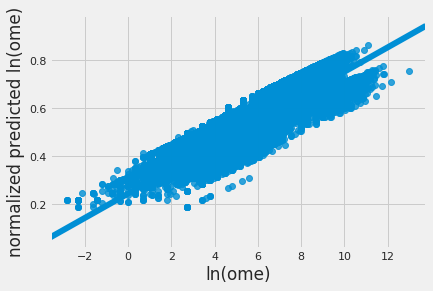

In [73]:
predicted = model.predict(X_model)

sns.regplot(sub_df['26'],predicted)
plt.xlabel('ln(ome)')
plt.ylabel('normalized predicted ln(ome)')

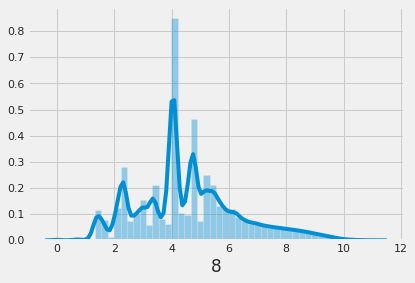

In [58]:
sns.distplot(np.log(ome_df_new['8']))

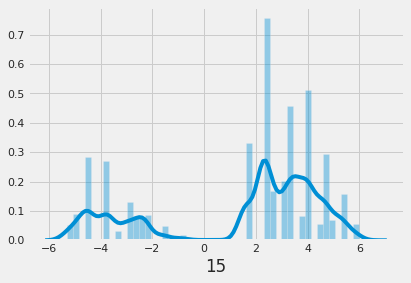

In [59]:
sns.distplot(np.log(ome_df_new['15']))

In [63]:
drug_identifiers = opioids_ome['24'].unique()

In [105]:
features = {'ome':[], 'mean_pills':[], 'sigma_pills':[],'mean_potency':[], 'sigma_potency' : [] , 'BNF':[] , 'mean_cost':[] ,'sigma_cost':[] , 'mean_dosage':[] , 'sigma_dosage':[] }
for name , group in opioids_ome.groupby('24'):
#     if bnf_ome_map[name] < 10:
    features['BNF'].append(name)
    features['mean_pills'].append(np.mean(group['8']))
    features['sigma_pills'].append(np.std(group['8']))
    features['mean_potency'].append(np.mean(group['15']))
#     features['min_potency'].append(np.min(group['15']))
#     features['max_potency'].append(np.max(group['15']))
    features['sigma_potency'].append(np.std(group['15']))
    features['mean_cost'].append(np.mean(group['7']))
    features['sigma_cost'].append(np.std(group['7']))
    features['mean_dosage'].append(np.mean(group['19']))
    features['sigma_dosage'].append(np.std(group['19']))
    features['ome'].append(bnf_ome_map[name])
features = pd.DataFrame.from_dict(features)

In [106]:
features = features[features['mean_potency']!=0]

In [107]:
features.head()

,BNF,mean_cost,mean_dosage,mean_pills,mean_potency,ome,sigma_cost,sigma_dosage,sigma_pills,sigma_potency
0,040702020AAAA,8.667778,26.666667,5.333333,50.0,2.0,4.889955,15.092309,3.018462,0.0
1,040702020AAAB,16.110000,47.500000,9.500000,50.0,2.0,11.070000,32.500000,6.500000,0.0
2,040702020BBAA,17.891000,11.000000,11.000000,10.0,2.0,22.330664,13.791302,13.791302,0.0
3,040702020BBAB,69.463448,61.758621,41.172414,15.0,2.0,119.063825,105.946035,70.630690,0.0
4,040702040AAAA,206.694329,6755.102452,6755.102452,50.0,0.1,184.692521,6033.661176,6033.661176,0.0


In [108]:
features[features['mean_potency'] == 0.0]

,BNF,mean_cost,mean_dosage,mean_pills,mean_potency,ome,sigma_cost,sigma_dosage,sigma_pills,sigma_potency


[Text(0,0.5,'mean_cost'),
 Text(0,1.5,'mean_dosage'),
 Text(0,2.5,'mean_pills'),
 Text(0,3.5,'mean_potency'),
 Text(0,4.5,'ome'),
 Text(0,5.5,'sigma_cost'),
 Text(0,6.5,'sigma_dosage'),
 Text(0,7.5,'sigma_pills'),
 Text(0,8.5,'sigma_potency')]

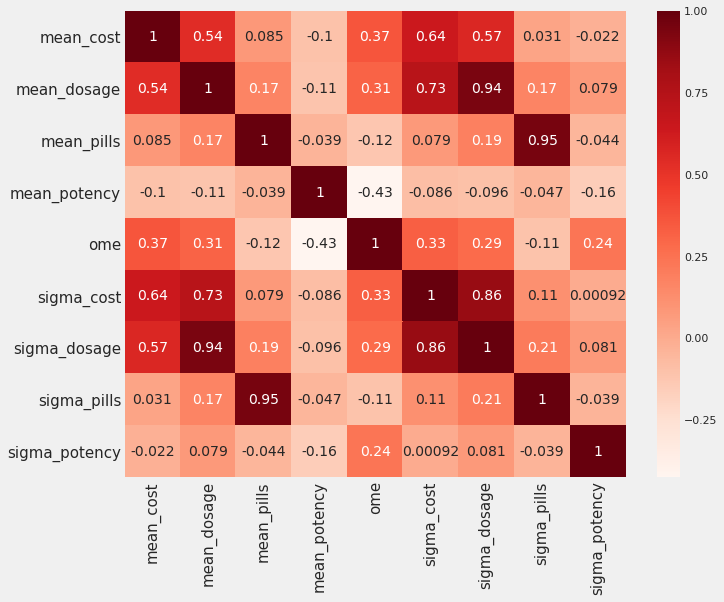

In [109]:
fig, ax = plt.subplots(figsize=(10,8))         
corr = features.corr(method='pearson')
sns.heatmap(corr, annot=True , ax=ax ,cmap='Reds' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15)

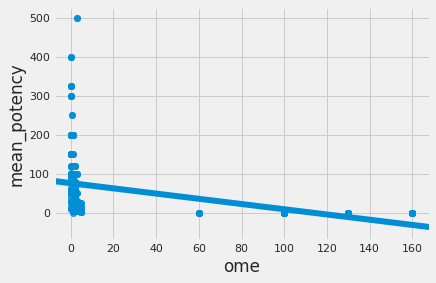

In [77]:
sns.regplot(features['ome'],features['mean_potency'])

Text(0.5,0,'ln(mean_dosage)')

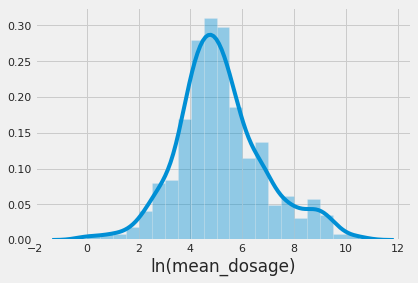

In [100]:
sns.distplot(np.log(features['mean_dosage']))
plt.xlabel("ln(mean_dosage)")

Text(0.5,0,'ln(mean_cost)')

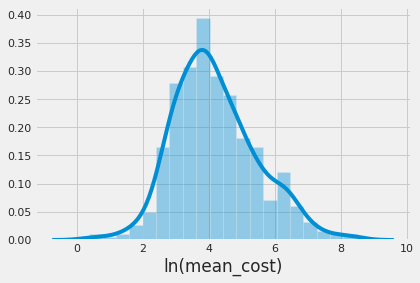

In [101]:
sns.distplot(np.log(features['mean_cost']))
plt.xlabel("ln(mean_cost)")

Text(0.5,0,'ln(mean_potecy)')

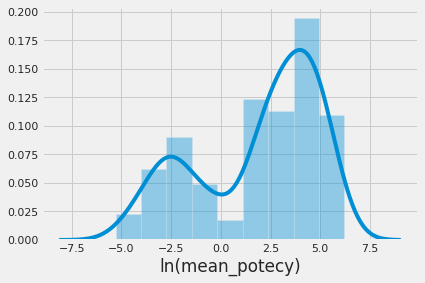

In [102]:
sns.distplot(np.log(features['mean_potency']))
plt.xlabel("ln(mean_potecy)")

Text(0.5,0,'ln(ome)')

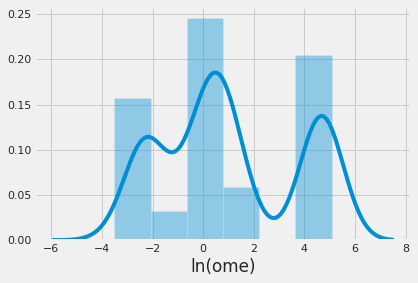

In [103]:
sns.distplot(np.log(features['ome']))
plt.xlabel("ln(ome)")

In [121]:
features['ln_mean_potency'] = np.log(features['mean_potency'])
features['ln_mean_dosage'] = np.log(features['mean_dosage'])
features['ln_mean_cost'] = np.log(features['mean_potency'])
features['ln_mean_pills'] = np.log(features['mean_pills'])
features['ln_Impact'] = np.log(features['mean_potency']/features['mean_pills'])

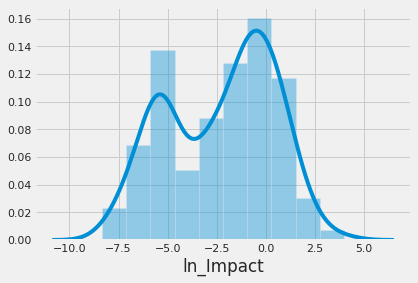

In [122]:
sns.distplot(features['ln_Impact'])

In [82]:
# features_to_normalize = ['ln_mean_potency','ln_mean_dosage','ln_mean_cost']
# features[features_to_normalize] = features[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [123]:
Y_dims = ['ome']
X_dims = ['ln_Impact']

min_max_scaler = preprocessing.MinMaxScaler() 
Y_ome = min_max_scaler.fit_transform(np.array(features[Y_dims].values,dtype=np.float32))
X_model = np.array(features[X_dims].values,dtype=np.float32)

X_model = sm.add_constant(X_model)
print(X_model)
model = sm.OLS(Y_ome, X_model).fit()
model.summary()

In [126]:
predicted = model.predict(X_model)

sns.regplot(np.log(features['ome']),predicted)
plt.xlabel('ln(ome)')
plt.ylabel('normalized predicted ln(ome)')